# Title: PCA analysis

In this part, I run the PCA analysis in the framework of the EDA to see if data with reduced dimensionality allow to distinguish between the three groups of patients. I also use the k-means algorithm to identify clusters in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data

In [2]:
import pandas as pd

data_ohe = pd.read_csv("data_ohe.csv")
print('Data shape', data_ohe.shape)
data_ohe.head()

Data shape (368, 152)


,sample_id,group,age,Alanine,Creatine,Creatinine,Glutamine,Glycine,Histidine,Isoleucine,...,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
0,6,2,72,0.411,0.016,0.088,0.705,0.274,0.063,0.077,...,1,0,0,0,0,1,0,0,1,0
1,7,2,89,0.379,0.018,0.069,0.696,0.538,0.034,0.062,...,1,0,0,0,1,0,0,0,0,1
2,9,2,82,0.362,0.058,0.117,0.657,0.311,0.054,0.054,...,1,0,0,0,1,0,0,0,1,0
3,19,2,56,0.394,0.007,0.100,0.783,0.227,0.067,0.084,...,1,0,0,0,0,1,0,1,0,0
4,20,2,87,0.224,0.122,0.155,0.452,0.220,0.055,0.033,...,1,0,0,0,0,1,0,0,0,1


# Data split / baseline

**Comment:** Note that the PCA are run on the subset of data with numerical features only. 

In [3]:
from sklearn.model_selection import train_test_split

data_mod=data_ohe.drop(['age', 'sample_id'], axis=1)
print('Shape of onehot encoded data ready for modeling:', data_mod.shape)
data_mod.head()

# Load the names of the numerical features
%store -r col_float64

# Create X/y variables
X = data_mod.drop(["group"], axis=1)
X=X[col_float64] # The PCA are run on numerical features only
y = data_mod.group

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=0 # Make sure to keep the same proportion of classes by setting stratify
)

print("Train:", X_tr.shape, y_tr.shape)
print("Test:", X_te.shape, y_te.shape)

Shape of onehot encoded data ready for modeling: (368, 150)
Train: (294, 139) (294,)
Test: (74, 139) (74,)


In [4]:
# Check the number of samples (patients) in each group
print(y_tr.value_counts())
print(y_tr.value_counts(normalize=True))

2    197
0     75
1     22
Name: group, dtype: int64
2    0.670068
0    0.255102
1    0.074830
Name: group, dtype: float64


In [5]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(None, y_tr)
print("Test accuracy: {:.2f}%".format(100 * dummy.score(None, y_te)))

Test accuracy: 66.22%


# PCA 

## PCA(n_components=none) with StandardScaler

In [6]:
# Standarize data
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_tr_rescaled = scaler.fit_transform(X_tr)

In [7]:
from sklearn.decomposition import PCA

# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA to rescaled data
pca.fit(X_tr_rescaled, y=None) # Unsupervised learning, no y variable

# Proportion of variance explained
pve = pca.explained_variance_ratio_
print(pve[:5])

print('Number of Principal Components' , len(pve))

[0.22008555 0.17196382 0.12987716 0.09371894 0.07623163]
Number of Principal Components 139


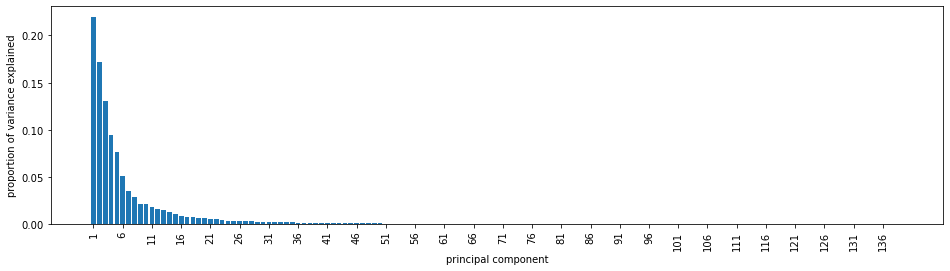

In [8]:
# Scree plot
plt.figure(figsize=(16,4))

# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor[::5])

# Add labels
plt.xlabel("principal component")
plt.xticks(rotation=90)
plt.ylabel("proportion of variance explained")
plt.show()

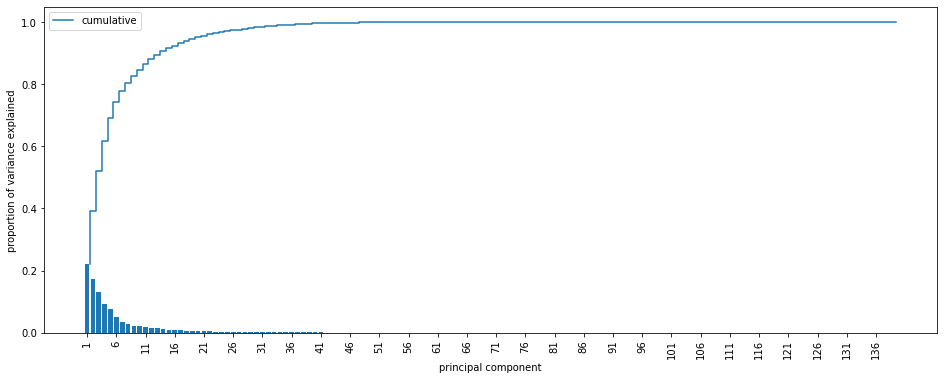

In [9]:
# Scree plot with cumulative sum

plt.figure(figsize=(16,6))

# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor[::5])

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor + 0.5,  # 1.5,2.5,..,n_components+0.5
    pve_cumsum,  # Cumulative sum
    label="cumulative",
)

# Add labels
plt.xlabel("principal component")
plt.xticks(rotation=90)
plt.ylabel("proportion of variance explained")
plt.legend()
plt.show()

In [10]:
# Find how many PCA components explain 50%, 60% and 100% of the variance?
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx+1, array[idx] # idx=0 corresponds to the 1st feature, that is why idx+1

variance=[50, 60, 70, 80, 90, 100]

for var in variance:
    print(find_nearest((pve_cumsum*100), var))

(3, 52.19265339473945)
(4, 61.56454717249083)
(5, 69.18771030627079)
(8, 80.5344999775834)
(13, 89.40765816218429)
(137, 99.99999999999993)


**Comment** Eight principal components explain 80.5% of variance. 

## PCA(n_components=2) with StandardScaler

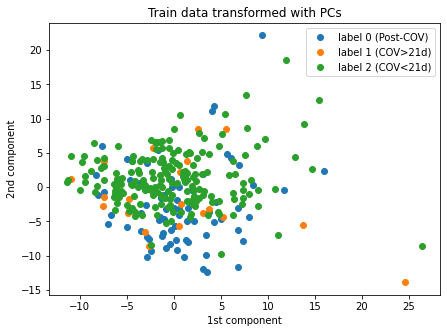

In [11]:
# Create PCA transformer
pca2 = PCA(n_components=2)

# Apply PCA 
X_tr_2d_rescaled = pca2.fit_transform(X_tr_rescaled)

group_labels=['Post-COV', 'COV>21d', 'COV<21d']

# Plot each patient category
plt.figure(figsize=(7,5))

for label in [0, 1, 2]:
    # Patiens with this label
    idx = y_tr == label

    # Plot their components
    plt.scatter(
        X_tr_2d_rescaled[idx, 0], X_tr_2d_rescaled[idx, 1], label="label {} ({})".format(label,group_labels[label])
    )

# Labels and legend
plt.legend()
plt.title("Train data transformed with PCs")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()

**Comment:** Two principal components explain only less that 50% of variance in the data. Yet, already with such a severe dimensionality reduction, the overlap of the points from groups 0 and 2 is only partial. The points from group 1 are dispersed and cover similar region as all the other points, suggesting that it may be challenging to build a classfier allowing to classify these points with a high accuracy. For sure, such classfier would need to be complex enough to capture the difference between datapoints from this group and the points from the other more extreme groups. 

In [12]:
# Create DataFrame with variance and principal components
results_df = pd.DataFrame(
    {
        "variance": X_tr_rescaled.var(axis=0),
        "1st component": pca2.components_[0],
        "2nd component": pca2.components_[1],
    }
).set_index(X_tr.columns)

# Sort DataFrame by the coefficients of the 1st loading vector
results_df.sort_values("1st component", key=abs, ascending=False).head(15)

,variance,1st component,2nd component
ApoB100,1.0,0.163671,-0.021770
TotalApoBParticleNumber,1.0,0.163670,-0.021771
Chol,1.0,0.148865,-0.080180
FreeCholesterol_IDL,1.0,0.146587,0.070275
Phospholipids_IDL,1.0,0.143892,0.087928
ApoB_LDL,1.0,0.143735,-0.065525
LDLParticleNumber,1.0,0.143734,-0.065524
IDLParticleNumber,1.0,0.141921,0.049542
ApoB_IDL,1.0,0.141916,0.049549
Cholesterol_IDL,1.0,0.139796,0.066323


**Comment:** In the table above, 15 substances are listed for which the 1st loading vector has a high coeffcient. The quantities of these substances may differ in the groups of patients (at least in the two most extreme groups 0 and 2), allowing to cluster the points from each group and distinguish betweeen them. These substances are mainly lipids, phospholipids and apoliproteins B.

In [13]:
# Create DataFrame with variance and principal components
results_df = pd.DataFrame(
    {
        "variance": X_tr_rescaled.var(axis=0),
        "1st component": pca2.components_[0],
        "2nd component": pca2.components_[1],
    }
).set_index(X_tr.columns)

# Sort DataFrame by the coefficients of the 2nd loading vector
results_df.sort_values("2nd component", key=abs, ascending=False).head(15)

,variance,1st component,2nd component
FreeCholesterol_VLDL3,1.0,0.098083,0.160497
ApoB_VLDL,1.0,0.109422,0.149067
VLDLParticleNumber,1.0,0.109425,0.149066
FreeCholesterol_VLDL2,1.0,0.090302,0.146285
Phospholipids_LDL3,1.0,0.092414,-0.145753
Phospholipids_VLDL,1.0,0.089214,0.145447
Triglycerides_VLDL2,1.0,0.081896,0.144137
FreeCholesterol_LDL3,1.0,0.092025,-0.143980
FreeCholesterol_VLDL,1.0,0.093148,0.143835
Phospholipids_VLDL3,1.0,0.091504,0.143824


**Comment:** In the table above, 15 substances are listed for which the 2nd loading vector has a high coeffcient. The quantities of these substances may differ in the groups of patients (at least in the two most extreme groups 0 and 2), allowing to cluster the points from each group and distinguish betweeen them. These substances are mainly lipids, phospholipids, apoliproteins B as well as Triglycerides.

## PCA(n_components=2) without StandardScaler

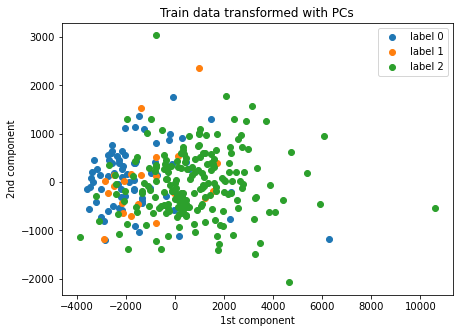

In [14]:
# Create PCA transformer
pca2 = PCA(n_components=2)

# Apply PCA 
X_tr_2d = pca2.fit_transform(X_tr)

group_labels=['Post-COV', 'COV>21d', 'COV<21d']

# Plot each patient category
plt.figure(figsize=(7,5))

for label in [0, 1, 2]:
    # Groups with this label
    idx = y_tr == label

    # Plot their components
    plt.scatter(
        X_tr_2d[idx, 0], X_tr_2d[idx, 1], label="label {}".format(label)
    )

# Labels and legend
plt.legend()
plt.title("Train data transformed with PCs")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()

**Comment:** Without the StandardScaler(), the separation between the blue and the green clusters seems to be even more pronounced. The orange datapoints seem to lie somewhat in-between the blue and the green points. The patients from group 1 (post acute phase of infection) are in the process of healing and may represent an intermediate stage between the two extreme stages (acute infection  and post-COVID). It should be noted however that doing PCA analysis on the non-scaled data will favour variables with a large variance. It is therefore recommended to scale the data so that all features have the same variance. In the following, I will apply PCA always after scaling the data with the StandardScaler().

In [15]:
# Create DataFrame with variance and principal components
results_df = pd.DataFrame(
    {
        "variance": X_tr.var(axis=0),
        "1st component": pca2.components_[0],
        "2nd component": pca2.components_[1],
    }
).set_index(X_tr.columns)

# Sort DataFrame by the coefficients of the 1st loading vector
results_df.sort_values("1st component", key=abs, ascending=False).head(15)

,variance,1st component,2nd component
Glycoproteins,4.199217e+06,0.992710,-0.092390
TotalApoBParticleNumber,2.471101e+05,0.085068,0.684306
LDL6ParticleNumber,3.724502e+04,0.044694,0.084445
LDLParticleNumber,2.134312e+05,0.040502,0.666343
VLDLParticleNumber,9.756629e+03,0.032058,0.027360
TG,6.151949e+03,0.026831,0.006923
Triglycerides_VLDL,5.052937e+03,0.024014,-0.003199
Triglycerides_VLDL1,4.536795e+03,0.018564,-0.011605
IDLParticleNumber,4.248239e+03,0.015982,0.051426
LDL2ParticleNumber,7.366359e+03,0.011975,0.054149


**Comment:** For example, the Glycoproteins and the TotalApoBParticleNumber have large variance and the PCA uses these two features as the Principla Components. 

## PCA(n_components=3) with StandardScaler

In [16]:
# Look at the data with dimensionality reducted to three PCs wth a 3D plot
%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
 
X_tr_3d_rescaled = pca3.fit_transform(X_tr_rescaled) 

group_labels=['Post-COV', 'COV>21d', 'COV<21d']
color=['blue', 'orange', 'green']
marker=['*','o','+']
alpha=[0.3,0.4,0.5]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for label in np.unique(y_tr):
    idx = y_tr == label
    # Plot the components
    ax.scatter(X_tr_3d_rescaled[idx, 0], X_tr_3d_rescaled[idx, 1], X_tr_3d_rescaled[idx, 2], 
               c=color[label], s=40, label="label {} ({})".format(label,group_labels[label]), marker=marker[label], alpha=alpha[label])

ax.set_xlabel("First PC", fontsize=12)
ax.set_ylabel("Second PC", fontsize=12)
ax.set_zlabel("Third PC", fontsize=12)

ax.legend()
plt.show()

**Comment:** Three PCs explain only a bit more than 52%. A decent separation is observed between datapoints from groups 0 and 2. Group 1 points are not well distinguished in the 3D plot either. 

## PCA(n_components=6) with StandardScaler

In [17]:
%matplotlib inline

In [18]:
pca6 = PCA(n_components=6)
X_tr_6d_rescaled = pca6.fit_transform(X_tr_rescaled) 

X_tr_6d_rescaled_df=pd.DataFrame(X_tr_6d_rescaled, columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
X_tr_6d_rescaled_df['y_tr']=list(y_tr)
X_tr_6d_rescaled_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,y_tr
0,3.471297,-12.365557,-1.865176,3.465110,0.010237,-1.358699,0
1,7.955131,-0.940223,7.491757,0.066037,3.202410,1.898276,2
2,-3.376660,-4.070975,-4.623183,2.443231,-0.938075,-3.246968,2
3,1.373368,3.819770,2.600984,-1.533890,-1.360488,2.853201,1
4,-3.040436,-0.169626,5.204594,1.755371,-0.583316,1.163760,1


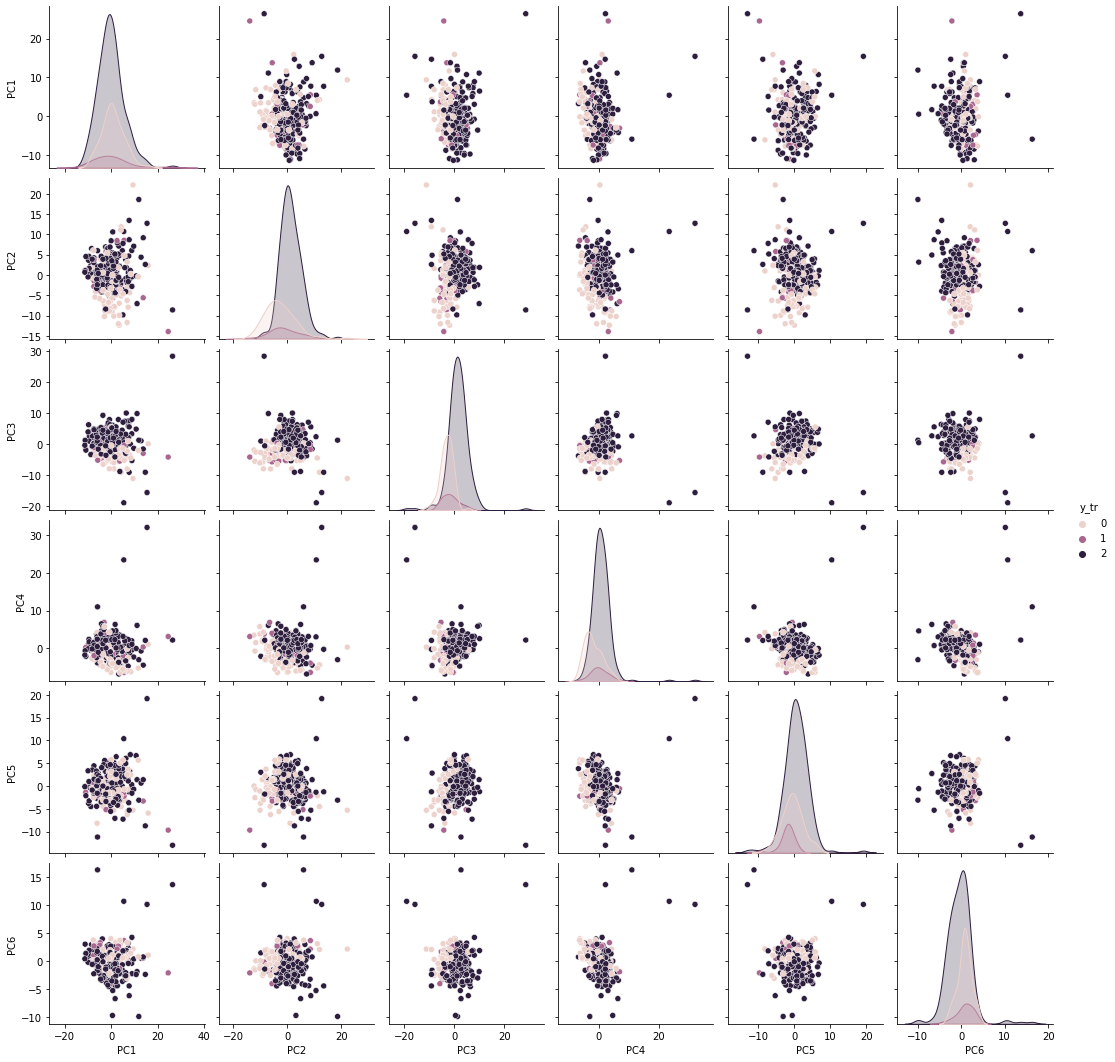

In [19]:
# Create pairplot to examine the pairs of teh Princial Components
sns.pairplot(
    X_tr_6d_rescaled_df,
    # Variables on the x-axes
    x_vars=['PC1','PC2','PC3','PC4','PC5','PC6'],
    # Variables on the y-axes
    y_vars=['PC1','PC2','PC3','PC4','PC5','PC6'], 
    # Use a different color for each group of patients
    hue="y_tr",
)

plt.show()

# PCA on data with two groups (1 and 2) only 

**Comment:** In this part I only want to look at two groups, instead of the three.

In [20]:
# Merge back X_tr and y_tr into one DataFrame in order to select only the groups 1 (post acute phase of infection) and 2 (acute phase of infection) and ignore group 1
X_tr_df=X_tr.copy()
X_tr_df["y_tr"]=y_tr
X_tr_df=X_tr_df[(X_tr_df["y_tr"]==1)|(X_tr_df["y_tr"]==2)]
print("Shape of data with two groups only", X_tr_df.shape)
print("Samples per group", X_tr_df.groupby('y_tr').size())
      
X_tr_bin=X_tr_df.drop(["y_tr"], axis=1)
y_tr_bin=X_tr_df["y_tr"]
print(X_tr_bin.shape)
print(y_tr_bin.shape)

# Rescale data
X_tr_bin_rescaled = scaler.fit_transform(X_tr_bin)

Shape of data with two groups only (219, 140)
Samples per group y_tr
1     22
2    197
dtype: int64
(219, 139)
(219,)


## Oversample with SMOTE and random undersample for imbalanced dataset

In this part, I will try the SMOTE (Synthetic Minority Oversampling Technique) startegy to account for the class imbalance. This method allows to produce synthetic points to increase the size of the minority class.

In [21]:
# Oversample the minority class with SMOTE 

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# summarize class distribution
counter = Counter(y_tr_bin)
print(counter)

# transform the dataset
sm = SMOTE(sampling_strategy = {2: 197, 1: 100})
X_bal, y_bal = sm.fit_resample(X_tr_bin_rescaled, y_tr_bin)

# summarize the new class distribution
counter = Counter(y_bal)
print(counter)

Counter({2: 197, 1: 22})
Counter({2: 197, 1: 100})


### PCA(n_components=None) with StandardScaler

In [22]:
# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA to rescaled data
pca.fit(X_bal, y=None) # Unsupervised learning, no y variable

# Proportion of variance explained
pve = pca.explained_variance_ratio_
print(pve[:5])

print('Number of Principal Components' , len(pve))

[0.29921776 0.15561292 0.11765165 0.08349999 0.06539408]
Number of Principal Components 139


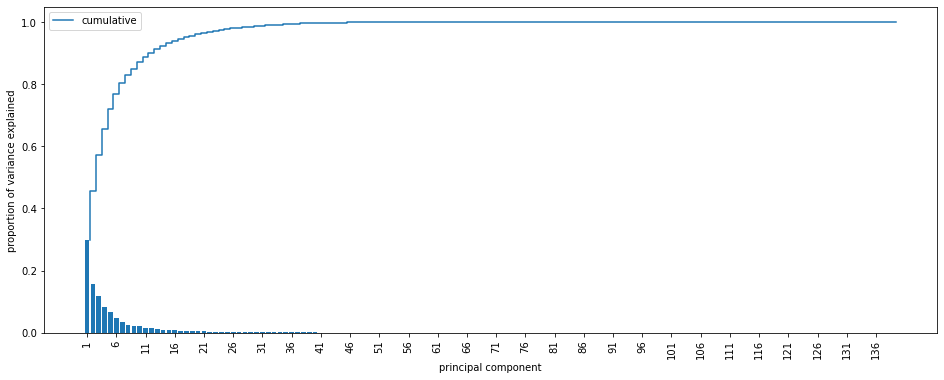

In [23]:
# Scree plot with cumulative sum

plt.figure(figsize=(16,6))

# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor[::5])

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor + 0.5,  # 1.5,2.5,..,n_components+0.5
    pve_cumsum,  # Cumulative sum
    label="cumulative",
)

# Add labels
plt.xlabel("principal component")
plt.xticks(rotation=90)
plt.ylabel("proportion of variance explained")
plt.legend()
plt.show()

In [24]:
# Find how many PCA components explain 50%, 60% and 100% of the variance?
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx+1, array[idx] # idx=0 corresponds to the 1st feature, that is why idx+1

variance=[50, 60, 70, 80, 90, 100]

for var in variance:
    print(find_nearest((pve_cumsum*100), var))

(2, 45.48306868031644)
(3, 57.2482334695067)
(5, 72.13764041336005)
(7, 80.23074558577147)
(12, 89.98441048809657)
(137, 100.00000000000003)


**Comment:** Twelve Principal Components explain almost 90% of the variance in the data.

### PCA(n_components=2) with StandardScaler

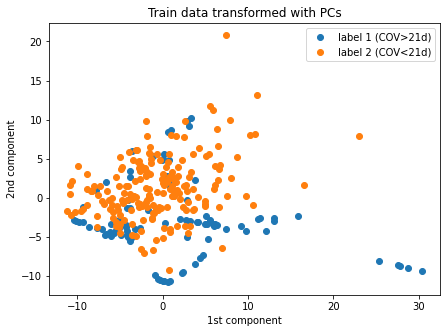

In [25]:
%matplotlib inline

# Create PCA transformer
pca2 = PCA(n_components=2)

# Apply PCA 
X_bal_2d_rescaled = pca2.fit_transform(X_bal)

label=[1, 2]
group_labels=['COV>21d', 'COV<21d']

# Plot each patient category
plt.figure(figsize=(7,5))

for i in range(len(label)):
    # Patiens with this label
    idx = y_bal == label[i]

    # Plot their components
    plt.scatter(
       X_bal_2d_rescaled[idx, 0], X_bal_2d_rescaled[idx, 1], label="label {} ({})".format(label[i], group_labels[i])
    )

# Labels and legend
plt.legend()
plt.title("Train data transformed with PCs")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()

**Comment:** Two Principal Components explain only less tahn 50% of teh variance in the data. The separation between the two classes is not clear from this plot. 

### PCA(n_components=6) with StandardScaler

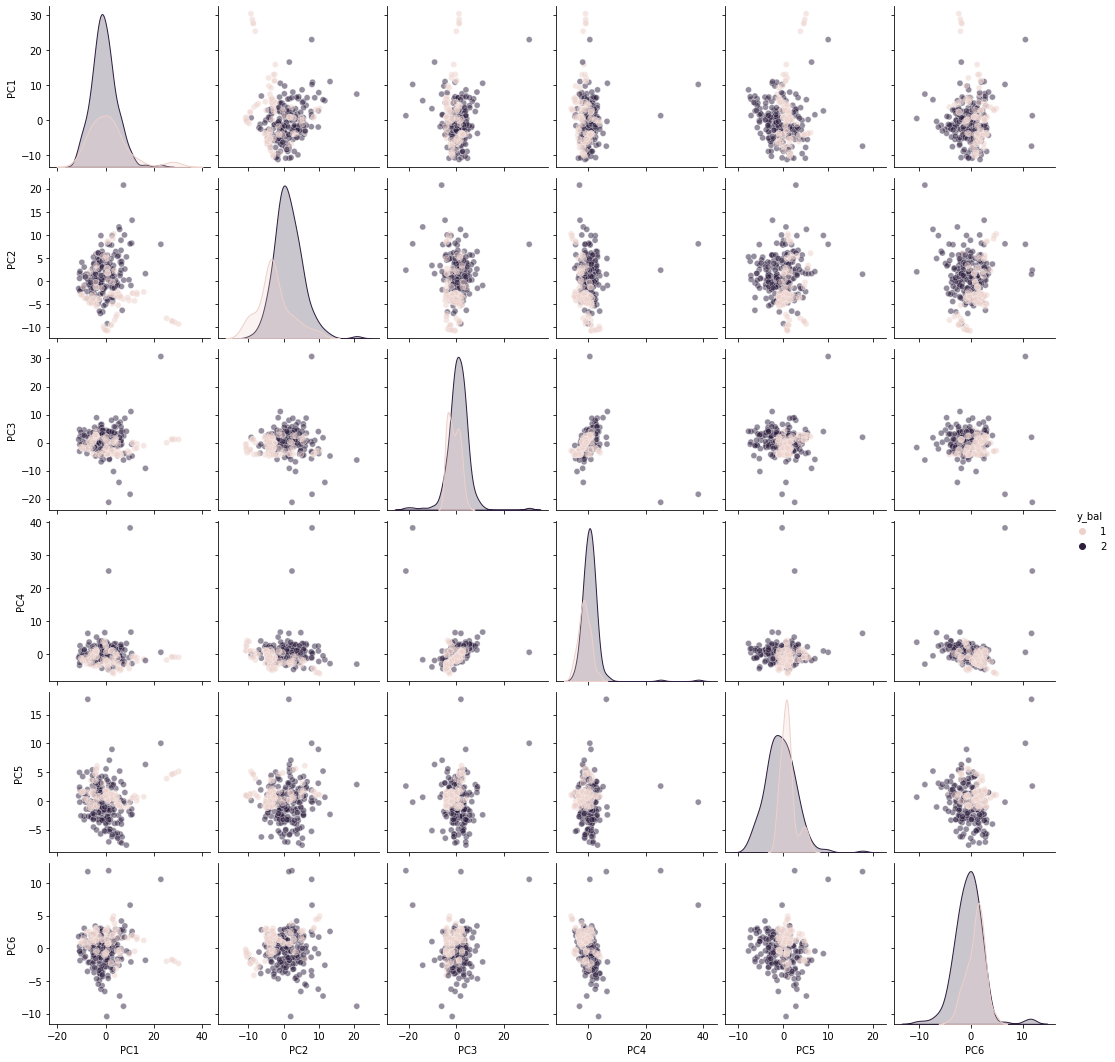

In [30]:
pca6 = PCA(n_components=6)
X_bal_6d_rescaled = pca6.fit_transform(X_bal) 

X_bal_6d_rescaled_df=pd.DataFrame(X_bal_6d_rescaled, columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
X_bal_6d_rescaled_df['y_bal']=list(y_bal)

# Create pairplot
sns.pairplot(
    X_bal_6d_rescaled_df,
    # Variables on the x-axes
    x_vars=['PC1','PC2','PC3','PC4','PC5','PC6'],
    # Variables on the y-axes
    y_vars=['PC1','PC2','PC3','PC4','PC5','PC6'], 
    # Use a different color for each group of patients
    hue="y_bal",
    plot_kws={'alpha':0.5}
)

plt.show()

**Comment:** In some of the scatterplots of the pairs of the PCs, the separation between the two groups of points is well visible. 

# k-means

In [27]:
from sklearn.cluster import KMeans

# Create k-means object
kmeans = KMeans(n_clusters=3, random_state=0)  # Fix results

In [28]:
# Fit it to the data
kmeans.fit(X_tr_2d_rescaled, y=None)

KMeans(n_clusters=3, random_state=0)

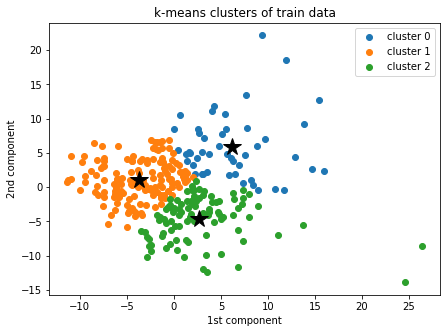

In [29]:
%matplotlib inline
# Plot clusters
plt.figure(figsize=(7,5))

for cluster in [0, 1, 2]:
    # Get points in this cluster
    idx = kmeans.labels_ == cluster

    # Plot their components
    plt.scatter(
        X_tr_2d_rescaled[idx, 0], X_tr_2d_rescaled[idx, 1], label="cluster {}".format(cluster)
    )

    # Plot centroid
    centroid = kmeans.cluster_centers_[cluster]
    plt.plot(centroid[0], centroid[1], marker="*", color="black", markersize=18)

# Add legend and labels
plt.legend()
plt.title("k-means clusters of train data")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()